# MLP 2 - FashionMNIST

In [2]:
import numpy as np
import cupy as cp
import pathlib
import pickle
import csv
import sys

In [2]:
sys.path.append(str(pathlib.Path('../../').resolve()))

In [3]:
from lib.experiments import train_test_experiment, build_MLP, build_augmentation_pipeline
from lib.utils.enums import NonLinearity, Initialization, Dataset, OptimizerName
from lib.utils.data import load_integer_dataset

## Experiments config

In [5]:
num_fc_layers = 4
num_fc_hidden = [200, 100, 50]

In [6]:
dataset_config = dict(
    dataset=Dataset.FASHION_MNIST.name,
    subsample_ratio=1.0,
    ohe_values=(0, 32),
    data_augmentation=False,
    normalize=True,
)

In [7]:
network_config = dict(
    num_fc_layers=num_fc_layers,
    num_fc_hidden=num_fc_hidden,
    non_linearity=NonLinearity.NITRO_LEAKY_RELU.name,
    init=Initialization.UNIFORM_KAIMING_LEAKY_RELU.name,
    dropout_rate=0.0,
    seed=42,
    dtype='int32',
    device='cuda',
    local_loss='pred',
    bias=False,
    debug=False,
)

In [8]:
training_config = dict(
    batch_size=64,
    num_epochs=150,
    lr_inv=512,
    lr_amp_factor=640,
    fwd_decay_inv=10_000,
    subnet_decay_inv=8000,
    optimizer=OptimizerName.INTEGER_SGD.name,
)

In [9]:
config = dataset_config | network_config | training_config

## Run the configuration

Training on 60000 samples


Data normalized. New statistics:
-  Min: -45
-  Max: 114
- Mean: 0
-  Std: 55

Moved data to device: <CUDA Device 1>
Train set:  (60000, 1, 28, 28), (60000, 10)
Test set:   (10000, 1, 28, 28), (10000, 10)
Data types: (int8, int8)


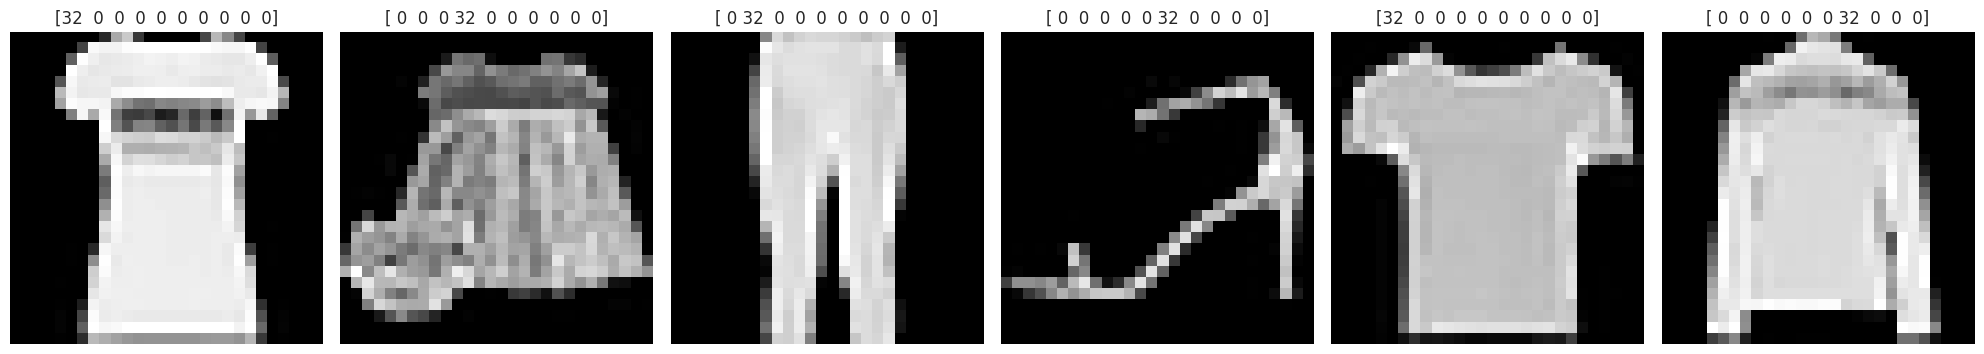

In [10]:
# Show the data and the model
dataset = load_integer_dataset(config, ohe_values=config["ohe_values"], val_dim=0, show_images=True, data_path='../.data')
X_train, _, _, y_train, _, _ = dataset

In [11]:
model = build_MLP(config, X_tr=X_train, y_tr=y_train)
print(model.extra_repr(1))

IntegerLocalLossMLP(
	(0): Sequential(
			(0): Flatten()
			(1): LocalLinearBlock(
			(0): IntegerLinear(in_features=784, out_features=200, bias=False, decay_rate_inv=10000)
			(1): ConstantScaling(fwd_factor=200704, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): IntegerLinear(in_features=200, out_features=10, bias=False, decay_rate_inv=8000)
			(1): ConstantScaling(fwd_factor=51200, bwd_factor=1)
		)
	)
			(2): LocalLinearBlock(
			(0): IntegerLinear(in_features=200, out_features=100, bias=False, decay_rate_inv=10000)
			(1): ConstantScaling(fwd_factor=51200, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): IntegerLinear(in_features=100, out_features=10, bias=False, decay_rate_inv=8000)
			(1): ConstantScaling(fwd_factor=25600, bwd_factor=1)
		)
	)
			(3): LocalLinearBlock(
			(0): IntegerLinear(in_features=100, out_features=50, bias=False, decay_rate_inv=10000)
			(1): ConstantSc

In [12]:
def run_experiment(exp_config):
    # Setup reproducibility
    print(f"{'-' * 64}")
    print(f"Running experiment with seed {exp_config['seed']}...")
    np.random.seed(exp_config["seed"])
    cp.random.seed(exp_config["seed"])
    
    # Load the dataset
    data = load_integer_dataset(exp_config, ohe_values=exp_config["ohe_values"], val_dim=0, show_images=False, show_log=False, data_path='../.data')
    X_tr, _, X_test, y_tr, _, y_test = data

    # Setup data augmentation
    augmentation_pipeline = build_augmentation_pipeline(exp_config)
    
    # Build and train the model
    m = build_MLP(exp_config, X_tr=X_tr, y_tr=y_tr)    
    best_train_acc, best_test_acc = train_test_experiment(
        m, exp_config, X_tr=X_tr, X_te=X_test, y_tr=y_tr, y_te=y_test,
        augmentation_pipeline=augmentation_pipeline,
        show_local_accuracies=False, show_progress_bar=False
    )

    # Append the results to a CSV file
    with open('./results.csv', mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([exp_config["seed"], best_train_acc, best_test_acc])
        
    # Save the first model
    if not pathlib.Path('model.pkl').exists():
        with open('model.pkl', 'wb') as f:
            pickle.dump(m, f)

In [13]:
N_EXPERIMENTS = 10
for i in range(N_EXPERIMENTS):
    run_experiment(config)
    config["seed"] += 1

----------------------------------------------------------------
Running experiment with seed 42...


Epoch   1/150 - Train accuracy: 35.180% - Test accuracy: 75.761%


Epoch   2/150 - Train accuracy: 77.858% - Test accuracy: 80.228%


Epoch   3/150 - Train accuracy: 82.749% - Test accuracy: 83.263%


Epoch   4/150 - Train accuracy: 84.752% - Test accuracy: 83.764%


Epoch   5/150 - Train accuracy: 85.534% - Test accuracy: 84.044%


Epoch   6/150 - Train accuracy: 86.086% - Test accuracy: 84.906%


Epoch   7/150 - Train accuracy: 86.524% - Test accuracy: 84.856%


Epoch   8/150 - Train accuracy: 86.916% - Test accuracy: 85.527%


Epoch   9/150 - Train accuracy: 87.200% - Test accuracy: 85.347%


Epoch  10/150 - Train accuracy: 87.458% - Test accuracy: 85.968%


Epoch  11/150 - Train accuracy: 87.663% - Test accuracy: 85.617%


Epoch  12/150 - Train accuracy: 87.880% - Test accuracy: 85.968%


Epoch  13/150 - Train accuracy: 87.994% - Test accuracy: 86.298%


Epoch  14/150 - Train accuracy: 88.164% - Test accuracy: 86.448%


Epoch  15/150 - Train accuracy: 88.419% - Test accuracy: 86.849%


Epoch  16/150 - Train accuracy: 88.437% - Test accuracy: 86.278%


Epoch  17/150 - Train accuracy: 88.644% - Test accuracy: 86.508%


Epoch  18/150 - Train accuracy: 88.894% - Test accuracy: 86.929%


Epoch  19/150 - Train accuracy: 88.964% - Test accuracy: 87.069%


Epoch  20/150 - Train accuracy: 89.109% - Test accuracy: 87.039%


Epoch  21/150 - Train accuracy: 89.171% - Test accuracy: 87.089%


Epoch  22/150 - Train accuracy: 89.261% - Test accuracy: 87.099%


Epoch  23/150 - Train accuracy: 89.398% - Test accuracy: 87.230%


Epoch  24/150 - Train accuracy: 89.526% - Test accuracy: 87.550%


Epoch  25/150 - Train accuracy: 89.684% - Test accuracy: 87.119%


Epoch  26/150 - Train accuracy: 89.721% - Test accuracy: 87.480%


Epoch  27/150 - Train accuracy: 89.868% - Test accuracy: 87.490%


Epoch  28/150 - Train accuracy: 89.980% - Test accuracy: 86.879%


Epoch  29/150 - Train accuracy: 89.948% - Test accuracy: 87.580%


Epoch  30/150 - Train accuracy: 90.211% - Test accuracy: 87.109%


Epoch  31/150 - Train accuracy: 90.160% - Test accuracy: 87.129%


Epoch  32/150 - Train accuracy: 90.315% - Test accuracy: 87.310%


Epoch  33/150 - Train accuracy: 90.363% - Test accuracy: 87.891%


Epoch  34/150 - Train accuracy: 90.512% - Test accuracy: 87.841%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 34
----------------------------------------------------------------


Epoch  35/150 - Train accuracy: 91.015% - Test accuracy: 88.221%


Epoch  36/150 - Train accuracy: 91.122% - Test accuracy: 88.081%


Epoch  37/150 - Train accuracy: 91.192% - Test accuracy: 88.261%


Epoch  38/150 - Train accuracy: 91.194% - Test accuracy: 88.191%


Epoch  39/150 - Train accuracy: 91.152% - Test accuracy: 88.401%


Epoch  40/150 - Train accuracy: 91.282% - Test accuracy: 88.071%


Epoch  41/150 - Train accuracy: 91.295% - Test accuracy: 88.221%


Epoch  42/150 - Train accuracy: 91.352% - Test accuracy: 88.261%


Epoch  43/150 - Train accuracy: 91.402% - Test accuracy: 88.301%


Epoch  44/150 - Train accuracy: 91.415% - Test accuracy: 88.231%


Epoch  45/150 - Train accuracy: 91.467% - Test accuracy: 88.271%


Epoch  46/150 - Train accuracy: 91.447% - Test accuracy: 88.341%


Epoch  47/150 - Train accuracy: 91.420% - Test accuracy: 88.321%


Epoch  48/150 - Train accuracy: 91.542% - Test accuracy: 88.291%


Epoch  49/150 - Train accuracy: 91.564% - Test accuracy: 88.391%


Epoch  50/150 - Train accuracy: 91.602% - Test accuracy: 88.261%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 50
----------------------------------------------------------------


Epoch  51/150 - Train accuracy: 91.771% - Test accuracy: 88.472%


Epoch  52/150 - Train accuracy: 91.802% - Test accuracy: 88.431%


Epoch  53/150 - Train accuracy: 91.782% - Test accuracy: 88.421%


Epoch  54/150 - Train accuracy: 91.851% - Test accuracy: 88.582%


Epoch  55/150 - Train accuracy: 91.907% - Test accuracy: 88.562%


Epoch  56/150 - Train accuracy: 91.857% - Test accuracy: 88.552%


Epoch  57/150 - Train accuracy: 91.877% - Test accuracy: 88.582%


Epoch  58/150 - Train accuracy: 91.892% - Test accuracy: 88.632%


Epoch  59/150 - Train accuracy: 91.867% - Test accuracy: 88.452%


Epoch  60/150 - Train accuracy: 91.919% - Test accuracy: 88.492%


Epoch  61/150 - Train accuracy: 91.867% - Test accuracy: 88.472%


Epoch  62/150 - Train accuracy: 91.886% - Test accuracy: 88.472%


Epoch  63/150 - Train accuracy: 91.901% - Test accuracy: 88.532%


Epoch  64/150 - Train accuracy: 91.922% - Test accuracy: 88.381%


Epoch  65/150 - Train accuracy: 91.907% - Test accuracy: 88.532%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 65
----------------------------------------------------------------


Epoch  66/150 - Train accuracy: 91.987% - Test accuracy: 88.592%


Epoch  67/150 - Train accuracy: 91.987% - Test accuracy: 88.582%


Epoch  68/150 - Train accuracy: 91.989% - Test accuracy: 88.542%


Epoch  69/150 - Train accuracy: 91.999% - Test accuracy: 88.592%


Epoch  70/150 - Train accuracy: 92.001% - Test accuracy: 88.512%
----------------------------------------------------------------
Early stopping at epoch 70
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 43...


Epoch   1/150 - Train accuracy: 34.568% - Test accuracy: 72.937%


Epoch   2/150 - Train accuracy: 77.641% - Test accuracy: 79.167%


Epoch   3/150 - Train accuracy: 82.953% - Test accuracy: 83.353%


Epoch   4/150 - Train accuracy: 84.757% - Test accuracy: 83.764%


Epoch   5/150 - Train accuracy: 85.481% - Test accuracy: 84.465%


Epoch   6/150 - Train accuracy: 86.059% - Test accuracy: 85.106%


Epoch   7/150 - Train accuracy: 86.618% - Test accuracy: 85.146%


Epoch   8/150 - Train accuracy: 86.868% - Test accuracy: 85.136%


Epoch   9/150 - Train accuracy: 87.133% - Test accuracy: 85.367%


Epoch  10/150 - Train accuracy: 87.313% - Test accuracy: 85.517%


Epoch  11/150 - Train accuracy: 87.627% - Test accuracy: 85.877%


Epoch  12/150 - Train accuracy: 87.855% - Test accuracy: 85.447%


Epoch  13/150 - Train accuracy: 87.942% - Test accuracy: 86.649%


Epoch  14/150 - Train accuracy: 88.227% - Test accuracy: 86.068%


Epoch  15/150 - Train accuracy: 88.394% - Test accuracy: 86.528%


Epoch  16/150 - Train accuracy: 88.577% - Test accuracy: 86.478%


Epoch  17/150 - Train accuracy: 88.637% - Test accuracy: 86.839%


Epoch  18/150 - Train accuracy: 88.742% - Test accuracy: 86.789%


Epoch  19/150 - Train accuracy: 88.981% - Test accuracy: 86.909%


Epoch  20/150 - Train accuracy: 89.056% - Test accuracy: 86.589%


Epoch  21/150 - Train accuracy: 89.233% - Test accuracy: 86.869%


Epoch  22/150 - Train accuracy: 89.364% - Test accuracy: 87.179%


Epoch  23/150 - Train accuracy: 89.483% - Test accuracy: 87.079%


Epoch  24/150 - Train accuracy: 89.494% - Test accuracy: 87.390%


Epoch  25/150 - Train accuracy: 89.613% - Test accuracy: 87.400%


Epoch  26/150 - Train accuracy: 89.771% - Test accuracy: 87.670%


Epoch  27/150 - Train accuracy: 89.898% - Test accuracy: 87.450%


Epoch  28/150 - Train accuracy: 89.833% - Test accuracy: 87.660%


Epoch  29/150 - Train accuracy: 90.066% - Test accuracy: 87.540%


Epoch  30/150 - Train accuracy: 90.168% - Test accuracy: 87.450%


Epoch  31/150 - Train accuracy: 90.243% - Test accuracy: 87.480%


Epoch  32/150 - Train accuracy: 90.353% - Test accuracy: 87.881%


Epoch  33/150 - Train accuracy: 90.423% - Test accuracy: 87.710%


Epoch  34/150 - Train accuracy: 90.463% - Test accuracy: 88.201%


Epoch  35/150 - Train accuracy: 90.495% - Test accuracy: 87.650%


Epoch  36/150 - Train accuracy: 90.610% - Test accuracy: 88.301%


Epoch  37/150 - Train accuracy: 90.787% - Test accuracy: 88.241%


Epoch  38/150 - Train accuracy: 90.863% - Test accuracy: 87.610%


Epoch  39/150 - Train accuracy: 90.862% - Test accuracy: 88.261%


Epoch  40/150 - Train accuracy: 90.877% - Test accuracy: 87.881%


Epoch  41/150 - Train accuracy: 91.032% - Test accuracy: 86.759%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 41
----------------------------------------------------------------


Epoch  42/150 - Train accuracy: 91.557% - Test accuracy: 88.642%


Epoch  43/150 - Train accuracy: 91.619% - Test accuracy: 88.442%


Epoch  44/150 - Train accuracy: 91.764% - Test accuracy: 88.762%


Epoch  45/150 - Train accuracy: 91.724% - Test accuracy: 88.692%


Epoch  46/150 - Train accuracy: 91.856% - Test accuracy: 88.702%


Epoch  47/150 - Train accuracy: 91.851% - Test accuracy: 88.502%


Epoch  48/150 - Train accuracy: 91.817% - Test accuracy: 88.702%


Epoch  49/150 - Train accuracy: 91.871% - Test accuracy: 88.742%


Epoch  50/150 - Train accuracy: 91.911% - Test accuracy: 88.772%


Epoch  51/150 - Train accuracy: 91.924% - Test accuracy: 88.582%


Epoch  52/150 - Train accuracy: 91.967% - Test accuracy: 88.612%


Epoch  53/150 - Train accuracy: 91.926% - Test accuracy: 88.822%


Epoch  54/150 - Train accuracy: 91.989% - Test accuracy: 88.802%


Epoch  55/150 - Train accuracy: 92.102% - Test accuracy: 88.712%


Epoch  56/150 - Train accuracy: 92.104% - Test accuracy: 88.792%


Epoch  57/150 - Train accuracy: 92.064% - Test accuracy: 88.622%


Epoch  58/150 - Train accuracy: 92.136% - Test accuracy: 88.662%


Epoch  59/150 - Train accuracy: 92.144% - Test accuracy: 88.712%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 59
----------------------------------------------------------------


Epoch  60/150 - Train accuracy: 92.363% - Test accuracy: 89.052%


Epoch  61/150 - Train accuracy: 92.346% - Test accuracy: 88.822%


Epoch  62/150 - Train accuracy: 92.391% - Test accuracy: 88.882%


Epoch  63/150 - Train accuracy: 92.409% - Test accuracy: 88.982%


Epoch  64/150 - Train accuracy: 92.439% - Test accuracy: 88.932%


Epoch  65/150 - Train accuracy: 92.421% - Test accuracy: 88.792%


Epoch  66/150 - Train accuracy: 92.393% - Test accuracy: 88.952%


Epoch  67/150 - Train accuracy: 92.399% - Test accuracy: 88.932%


Epoch  68/150 - Train accuracy: 92.458% - Test accuracy: 88.972%


Epoch  69/150 - Train accuracy: 92.453% - Test accuracy: 88.902%


Epoch  70/150 - Train accuracy: 92.494% - Test accuracy: 88.922%


Epoch  71/150 - Train accuracy: 92.506% - Test accuracy: 88.872%


Epoch  72/150 - Train accuracy: 92.488% - Test accuracy: 88.882%


Epoch  73/150 - Train accuracy: 92.429% - Test accuracy: 88.912%


Epoch  74/150 - Train accuracy: 92.531% - Test accuracy: 88.862%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 74
----------------------------------------------------------------


Epoch  75/150 - Train accuracy: 92.586% - Test accuracy: 88.962%


Epoch  76/150 - Train accuracy: 92.606% - Test accuracy: 88.952%


Epoch  77/150 - Train accuracy: 92.609% - Test accuracy: 88.942%
----------------------------------------------------------------
Early stopping at epoch 77
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 44...


Epoch   1/150 - Train accuracy: 34.764% - Test accuracy: 70.152%


Epoch   2/150 - Train accuracy: 77.746% - Test accuracy: 79.898%


Epoch   3/150 - Train accuracy: 82.964% - Test accuracy: 83.013%


Epoch   4/150 - Train accuracy: 84.605% - Test accuracy: 84.225%


Epoch   5/150 - Train accuracy: 85.489% - Test accuracy: 84.555%


Epoch   6/150 - Train accuracy: 86.033% - Test accuracy: 84.675%


Epoch   7/150 - Train accuracy: 86.383% - Test accuracy: 85.016%


Epoch   8/150 - Train accuracy: 86.775% - Test accuracy: 85.066%


Epoch   9/150 - Train accuracy: 87.038% - Test accuracy: 85.747%


Epoch  10/150 - Train accuracy: 87.300% - Test accuracy: 85.917%


Epoch  11/150 - Train accuracy: 87.617% - Test accuracy: 85.707%


Epoch  12/150 - Train accuracy: 87.922% - Test accuracy: 86.078%


Epoch  13/150 - Train accuracy: 87.999% - Test accuracy: 85.927%


Epoch  14/150 - Train accuracy: 88.130% - Test accuracy: 86.689%


Epoch  15/150 - Train accuracy: 88.320% - Test accuracy: 86.468%


Epoch  16/150 - Train accuracy: 88.324% - Test accuracy: 86.558%


Epoch  17/150 - Train accuracy: 88.667% - Test accuracy: 86.428%


Epoch  18/150 - Train accuracy: 88.817% - Test accuracy: 86.548%


Epoch  19/150 - Train accuracy: 88.822% - Test accuracy: 86.438%


Epoch  20/150 - Train accuracy: 88.929% - Test accuracy: 86.819%


Epoch  21/150 - Train accuracy: 89.184% - Test accuracy: 86.979%


Epoch  22/150 - Train accuracy: 89.246% - Test accuracy: 87.210%


Epoch  23/150 - Train accuracy: 89.383% - Test accuracy: 87.200%


Epoch  24/150 - Train accuracy: 89.511% - Test accuracy: 86.929%


Epoch  25/150 - Train accuracy: 89.599% - Test accuracy: 87.360%


Epoch  26/150 - Train accuracy: 89.838% - Test accuracy: 86.999%


Epoch  27/150 - Train accuracy: 89.803% - Test accuracy: 87.340%


Epoch  28/150 - Train accuracy: 89.860% - Test accuracy: 87.129%


Epoch  29/150 - Train accuracy: 90.025% - Test accuracy: 86.839%


Epoch  30/150 - Train accuracy: 90.100% - Test accuracy: 87.680%


Epoch  31/150 - Train accuracy: 90.218% - Test accuracy: 87.901%


Epoch  32/150 - Train accuracy: 90.298% - Test accuracy: 87.760%


Epoch  33/150 - Train accuracy: 90.457% - Test accuracy: 87.370%


Epoch  34/150 - Train accuracy: 90.500% - Test accuracy: 87.931%


Epoch  35/150 - Train accuracy: 90.400% - Test accuracy: 87.911%


Epoch  36/150 - Train accuracy: 90.600% - Test accuracy: 87.991%


Epoch  37/150 - Train accuracy: 90.633% - Test accuracy: 87.981%


Epoch  38/150 - Train accuracy: 90.740% - Test accuracy: 87.861%


Epoch  39/150 - Train accuracy: 90.737% - Test accuracy: 87.670%


Epoch  40/150 - Train accuracy: 90.835% - Test accuracy: 87.580%


Epoch  41/150 - Train accuracy: 90.939% - Test accuracy: 88.151%


Epoch  42/150 - Train accuracy: 91.012% - Test accuracy: 88.011%


Epoch  43/150 - Train accuracy: 91.107% - Test accuracy: 88.151%


Epoch  44/150 - Train accuracy: 91.109% - Test accuracy: 87.670%


Epoch  45/150 - Train accuracy: 91.169% - Test accuracy: 88.161%


Epoch  46/150 - Train accuracy: 91.250% - Test accuracy: 88.431%


Epoch  47/150 - Train accuracy: 91.265% - Test accuracy: 88.512%


Epoch  48/150 - Train accuracy: 91.345% - Test accuracy: 87.760%


Epoch  49/150 - Train accuracy: 91.450% - Test accuracy: 87.240%


Epoch  50/150 - Train accuracy: 91.527% - Test accuracy: 88.201%


Epoch  51/150 - Train accuracy: 91.594% - Test accuracy: 87.300%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 51
----------------------------------------------------------------


Epoch  52/150 - Train accuracy: 92.112% - Test accuracy: 88.632%


Epoch  53/150 - Train accuracy: 92.233% - Test accuracy: 88.722%


Epoch  54/150 - Train accuracy: 92.326% - Test accuracy: 88.642%


Epoch  55/150 - Train accuracy: 92.261% - Test accuracy: 88.732%


Epoch  56/150 - Train accuracy: 92.471% - Test accuracy: 88.622%


Epoch  57/150 - Train accuracy: 92.401% - Test accuracy: 88.802%


Epoch  58/150 - Train accuracy: 92.408% - Test accuracy: 88.652%


Epoch  59/150 - Train accuracy: 92.471% - Test accuracy: 88.682%


Epoch  60/150 - Train accuracy: 92.533% - Test accuracy: 88.812%


Epoch  61/150 - Train accuracy: 92.528% - Test accuracy: 88.442%


Epoch  62/150 - Train accuracy: 92.473% - Test accuracy: 88.772%


Epoch  63/150 - Train accuracy: 92.508% - Test accuracy: 88.612%


Epoch  64/150 - Train accuracy: 92.628% - Test accuracy: 88.742%


Epoch  65/150 - Train accuracy: 92.646% - Test accuracy: 88.762%


Epoch  66/150 - Train accuracy: 92.654% - Test accuracy: 88.762%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 66
----------------------------------------------------------------


Epoch  67/150 - Train accuracy: 92.828% - Test accuracy: 88.872%


Epoch  68/150 - Train accuracy: 92.836% - Test accuracy: 88.762%


Epoch  69/150 - Train accuracy: 92.828% - Test accuracy: 88.772%


Epoch  70/150 - Train accuracy: 92.860% - Test accuracy: 88.762%


Epoch  71/150 - Train accuracy: 92.835% - Test accuracy: 88.792%


Epoch  72/150 - Train accuracy: 92.851% - Test accuracy: 88.682%


Epoch  73/150 - Train accuracy: 92.880% - Test accuracy: 88.752%


Epoch  74/150 - Train accuracy: 92.886% - Test accuracy: 88.852%


Epoch  75/150 - Train accuracy: 92.866% - Test accuracy: 88.862%


Epoch  76/150 - Train accuracy: 92.880% - Test accuracy: 88.822%


Epoch  77/150 - Train accuracy: 92.815% - Test accuracy: 88.742%


Epoch  78/150 - Train accuracy: 92.883% - Test accuracy: 88.712%


Epoch  79/150 - Train accuracy: 92.893% - Test accuracy: 88.922%


Epoch  80/150 - Train accuracy: 92.875% - Test accuracy: 88.742%


Epoch  81/150 - Train accuracy: 92.866% - Test accuracy: 88.792%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 81
----------------------------------------------------------------


Epoch  82/150 - Train accuracy: 92.961% - Test accuracy: 88.972%


Epoch  83/150 - Train accuracy: 93.005% - Test accuracy: 88.802%


Epoch  84/150 - Train accuracy: 92.968% - Test accuracy: 88.812%


Epoch  85/150 - Train accuracy: 92.978% - Test accuracy: 88.842%


Epoch  86/150 - Train accuracy: 92.986% - Test accuracy: 88.752%


Epoch  87/150 - Train accuracy: 92.990% - Test accuracy: 88.732%


Epoch  88/150 - Train accuracy: 93.008% - Test accuracy: 88.772%
----------------------------------------------------------------
Early stopping at epoch 88
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 45...


Epoch   1/150 - Train accuracy: 35.212% - Test accuracy: 70.823%


Epoch   2/150 - Train accuracy: 77.776% - Test accuracy: 80.839%


Epoch   3/150 - Train accuracy: 83.193% - Test accuracy: 83.133%


Epoch   4/150 - Train accuracy: 84.617% - Test accuracy: 83.864%


Epoch   5/150 - Train accuracy: 85.494% - Test accuracy: 84.054%


Epoch   6/150 - Train accuracy: 86.096% - Test accuracy: 84.746%


Epoch   7/150 - Train accuracy: 86.468% - Test accuracy: 84.696%


Epoch   8/150 - Train accuracy: 86.858% - Test accuracy: 85.256%


Epoch   9/150 - Train accuracy: 87.098% - Test accuracy: 85.377%


Epoch  10/150 - Train accuracy: 87.447% - Test accuracy: 86.088%


Epoch  11/150 - Train accuracy: 87.507% - Test accuracy: 85.437%


Epoch  12/150 - Train accuracy: 87.788% - Test accuracy: 85.998%


Epoch  13/150 - Train accuracy: 88.037% - Test accuracy: 86.478%


Epoch  14/150 - Train accuracy: 88.195% - Test accuracy: 86.408%


Epoch  15/150 - Train accuracy: 88.252% - Test accuracy: 86.208%


Epoch  16/150 - Train accuracy: 88.521% - Test accuracy: 86.408%


Epoch  17/150 - Train accuracy: 88.602% - Test accuracy: 86.839%


Epoch  18/150 - Train accuracy: 88.689% - Test accuracy: 86.759%


Epoch  19/150 - Train accuracy: 88.894% - Test accuracy: 87.019%


Epoch  20/150 - Train accuracy: 89.049% - Test accuracy: 87.129%


Epoch  21/150 - Train accuracy: 89.101% - Test accuracy: 87.009%


Epoch  22/150 - Train accuracy: 89.276% - Test accuracy: 87.190%


Epoch  23/150 - Train accuracy: 89.571% - Test accuracy: 87.129%


Epoch  24/150 - Train accuracy: 89.403% - Test accuracy: 87.490%


Epoch  25/150 - Train accuracy: 89.576% - Test accuracy: 87.560%


Epoch  26/150 - Train accuracy: 89.735% - Test accuracy: 87.450%


Epoch  27/150 - Train accuracy: 89.786% - Test accuracy: 87.490%


Epoch  28/150 - Train accuracy: 89.936% - Test accuracy: 87.380%


Epoch  29/150 - Train accuracy: 90.063% - Test accuracy: 87.570%


Epoch  30/150 - Train accuracy: 90.120% - Test accuracy: 87.420%


Epoch  31/150 - Train accuracy: 90.175% - Test accuracy: 87.670%


Epoch  32/150 - Train accuracy: 90.250% - Test accuracy: 87.410%


Epoch  33/150 - Train accuracy: 90.365% - Test accuracy: 87.851%


Epoch  34/150 - Train accuracy: 90.410% - Test accuracy: 87.911%


Epoch  35/150 - Train accuracy: 90.422% - Test accuracy: 87.250%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 35
----------------------------------------------------------------


Epoch  36/150 - Train accuracy: 91.092% - Test accuracy: 88.061%


Epoch  37/150 - Train accuracy: 91.065% - Test accuracy: 88.011%


Epoch  38/150 - Train accuracy: 91.214% - Test accuracy: 88.221%


Epoch  39/150 - Train accuracy: 91.227% - Test accuracy: 88.301%


Epoch  40/150 - Train accuracy: 91.164% - Test accuracy: 88.151%


Epoch  41/150 - Train accuracy: 91.317% - Test accuracy: 88.191%


Epoch  42/150 - Train accuracy: 91.305% - Test accuracy: 88.201%


Epoch  43/150 - Train accuracy: 91.339% - Test accuracy: 88.171%


Epoch  44/150 - Train accuracy: 91.387% - Test accuracy: 88.211%


Epoch  45/150 - Train accuracy: 91.445% - Test accuracy: 88.281%


Epoch  46/150 - Train accuracy: 91.407% - Test accuracy: 88.251%


Epoch  47/150 - Train accuracy: 91.457% - Test accuracy: 88.051%


Epoch  48/150 - Train accuracy: 91.452% - Test accuracy: 88.411%


Epoch  49/150 - Train accuracy: 91.470% - Test accuracy: 88.241%


Epoch  50/150 - Train accuracy: 91.557% - Test accuracy: 88.341%


Epoch  51/150 - Train accuracy: 91.514% - Test accuracy: 88.221%


Epoch  52/150 - Train accuracy: 91.599% - Test accuracy: 88.341%


Epoch  53/150 - Train accuracy: 91.586% - Test accuracy: 88.261%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 53
----------------------------------------------------------------


Epoch  54/150 - Train accuracy: 91.862% - Test accuracy: 88.351%


Epoch  55/150 - Train accuracy: 91.836% - Test accuracy: 88.271%


Epoch  56/150 - Train accuracy: 91.877% - Test accuracy: 88.331%


Epoch  57/150 - Train accuracy: 91.864% - Test accuracy: 88.381%


Epoch  58/150 - Train accuracy: 91.884% - Test accuracy: 88.371%


Epoch  59/150 - Train accuracy: 91.899% - Test accuracy: 88.371%


Epoch  60/150 - Train accuracy: 91.881% - Test accuracy: 88.201%


Epoch  61/150 - Train accuracy: 91.911% - Test accuracy: 88.271%


Epoch  62/150 - Train accuracy: 91.902% - Test accuracy: 88.331%


Epoch  63/150 - Train accuracy: 91.952% - Test accuracy: 88.361%


Epoch  64/150 - Train accuracy: 91.899% - Test accuracy: 88.371%


Epoch  65/150 - Train accuracy: 91.947% - Test accuracy: 88.371%
----------------------------------------------------------------
Early stopping at epoch 65
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 46...


Epoch   1/150 - Train accuracy: 35.376% - Test accuracy: 73.968%


Epoch   2/150 - Train accuracy: 77.982% - Test accuracy: 79.778%


Epoch   3/150 - Train accuracy: 82.951% - Test accuracy: 83.403%


Epoch   4/150 - Train accuracy: 84.690% - Test accuracy: 84.195%


Epoch   5/150 - Train accuracy: 85.456% - Test accuracy: 84.816%


Epoch   6/150 - Train accuracy: 86.004% - Test accuracy: 84.445%


Epoch   7/150 - Train accuracy: 86.431% - Test accuracy: 85.286%


Epoch   8/150 - Train accuracy: 86.718% - Test accuracy: 84.726%


Epoch   9/150 - Train accuracy: 87.035% - Test accuracy: 85.517%


Epoch  10/150 - Train accuracy: 87.310% - Test accuracy: 85.687%


Epoch  11/150 - Train accuracy: 87.485% - Test accuracy: 86.178%


Epoch  12/150 - Train accuracy: 87.740% - Test accuracy: 85.958%


Epoch  13/150 - Train accuracy: 87.985% - Test accuracy: 86.218%


Epoch  14/150 - Train accuracy: 88.157% - Test accuracy: 86.238%


Epoch  15/150 - Train accuracy: 88.232% - Test accuracy: 85.797%


Epoch  16/150 - Train accuracy: 88.444% - Test accuracy: 86.749%


Epoch  17/150 - Train accuracy: 88.481% - Test accuracy: 86.558%


Epoch  18/150 - Train accuracy: 88.729% - Test accuracy: 86.498%


Epoch  19/150 - Train accuracy: 88.787% - Test accuracy: 86.398%


Epoch  20/150 - Train accuracy: 88.934% - Test accuracy: 86.508%


Epoch  21/150 - Train accuracy: 89.014% - Test accuracy: 86.879%


Epoch  22/150 - Train accuracy: 89.211% - Test accuracy: 87.169%


Epoch  23/150 - Train accuracy: 89.264% - Test accuracy: 86.849%


Epoch  24/150 - Train accuracy: 89.379% - Test accuracy: 86.428%


Epoch  25/150 - Train accuracy: 89.479% - Test accuracy: 86.979%


Epoch  26/150 - Train accuracy: 89.576% - Test accuracy: 87.179%


Epoch  27/150 - Train accuracy: 89.661% - Test accuracy: 87.169%


Epoch  28/150 - Train accuracy: 89.671% - Test accuracy: 87.089%


Epoch  29/150 - Train accuracy: 89.883% - Test accuracy: 87.400%


Epoch  30/150 - Train accuracy: 90.001% - Test accuracy: 87.760%


Epoch  31/150 - Train accuracy: 90.143% - Test accuracy: 87.520%


Epoch  32/150 - Train accuracy: 90.085% - Test accuracy: 87.500%


Epoch  33/150 - Train accuracy: 90.206% - Test accuracy: 87.049%


Epoch  34/150 - Train accuracy: 90.301% - Test accuracy: 87.490%


Epoch  35/150 - Train accuracy: 90.415% - Test accuracy: 87.590%


Epoch  36/150 - Train accuracy: 90.473% - Test accuracy: 86.689%


Epoch  37/150 - Train accuracy: 90.527% - Test accuracy: 87.520%


Epoch  38/150 - Train accuracy: 90.538% - Test accuracy: 87.770%


Epoch  39/150 - Train accuracy: 90.675% - Test accuracy: 88.051%


Epoch  40/150 - Train accuracy: 90.787% - Test accuracy: 87.750%


Epoch  41/150 - Train accuracy: 90.822% - Test accuracy: 87.179%


Epoch  42/150 - Train accuracy: 90.863% - Test accuracy: 87.690%


Epoch  43/150 - Train accuracy: 91.009% - Test accuracy: 88.181%


Epoch  44/150 - Train accuracy: 91.149% - Test accuracy: 88.051%


Epoch  45/150 - Train accuracy: 91.100% - Test accuracy: 87.670%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 45
----------------------------------------------------------------


Epoch  46/150 - Train accuracy: 91.654% - Test accuracy: 88.311%


Epoch  47/150 - Train accuracy: 91.706% - Test accuracy: 88.161%


Epoch  48/150 - Train accuracy: 91.779% - Test accuracy: 88.462%


Epoch  49/150 - Train accuracy: 91.881% - Test accuracy: 88.361%


Epoch  50/150 - Train accuracy: 91.934% - Test accuracy: 88.381%


Epoch  51/150 - Train accuracy: 91.876% - Test accuracy: 88.482%


Epoch  52/150 - Train accuracy: 91.959% - Test accuracy: 88.472%


Epoch  53/150 - Train accuracy: 91.989% - Test accuracy: 88.331%


Epoch  54/150 - Train accuracy: 91.947% - Test accuracy: 88.502%


Epoch  55/150 - Train accuracy: 92.051% - Test accuracy: 88.482%


Epoch  56/150 - Train accuracy: 92.092% - Test accuracy: 88.602%


Epoch  57/150 - Train accuracy: 92.052% - Test accuracy: 88.552%


Epoch  58/150 - Train accuracy: 92.126% - Test accuracy: 88.431%


Epoch  59/150 - Train accuracy: 92.147% - Test accuracy: 88.431%


Epoch  60/150 - Train accuracy: 92.124% - Test accuracy: 88.452%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 60
----------------------------------------------------------------


Epoch  61/150 - Train accuracy: 92.313% - Test accuracy: 88.602%


Epoch  62/150 - Train accuracy: 92.359% - Test accuracy: 88.692%


Epoch  63/150 - Train accuracy: 92.434% - Test accuracy: 88.612%


Epoch  64/150 - Train accuracy: 92.363% - Test accuracy: 88.752%


Epoch  65/150 - Train accuracy: 92.446% - Test accuracy: 88.662%
----------------------------------------------------------------
Early stopping at epoch 65
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 47...


Epoch   1/150 - Train accuracy: 34.563% - Test accuracy: 72.616%


Epoch   2/150 - Train accuracy: 77.633% - Test accuracy: 79.748%


Epoch   3/150 - Train accuracy: 83.149% - Test accuracy: 83.654%


Epoch   4/150 - Train accuracy: 84.742% - Test accuracy: 83.684%


Epoch   5/150 - Train accuracy: 85.599% - Test accuracy: 84.445%


Epoch   6/150 - Train accuracy: 85.931% - Test accuracy: 84.836%


Epoch   7/150 - Train accuracy: 86.446% - Test accuracy: 84.655%


Epoch   8/150 - Train accuracy: 86.821% - Test accuracy: 85.477%


Epoch   9/150 - Train accuracy: 87.090% - Test accuracy: 85.787%


Epoch  10/150 - Train accuracy: 87.335% - Test accuracy: 85.417%


Epoch  11/150 - Train accuracy: 87.518% - Test accuracy: 86.028%


Epoch  12/150 - Train accuracy: 87.755% - Test accuracy: 86.088%


Epoch  13/150 - Train accuracy: 88.017% - Test accuracy: 86.478%


Epoch  14/150 - Train accuracy: 88.207% - Test accuracy: 86.228%


Epoch  15/150 - Train accuracy: 88.294% - Test accuracy: 86.639%


Epoch  16/150 - Train accuracy: 88.404% - Test accuracy: 86.939%


Epoch  17/150 - Train accuracy: 88.591% - Test accuracy: 86.829%


Epoch  18/150 - Train accuracy: 88.756% - Test accuracy: 86.749%


Epoch  19/150 - Train accuracy: 88.789% - Test accuracy: 87.039%


Epoch  20/150 - Train accuracy: 89.014% - Test accuracy: 86.739%


Epoch  21/150 - Train accuracy: 89.179% - Test accuracy: 86.889%


Epoch  22/150 - Train accuracy: 89.299% - Test accuracy: 87.059%


Epoch  23/150 - Train accuracy: 89.293% - Test accuracy: 87.179%


Epoch  24/150 - Train accuracy: 89.443% - Test accuracy: 87.400%


Epoch  25/150 - Train accuracy: 89.483% - Test accuracy: 87.530%


Epoch  26/150 - Train accuracy: 89.606% - Test accuracy: 87.570%


Epoch  27/150 - Train accuracy: 89.668% - Test accuracy: 87.210%


Epoch  28/150 - Train accuracy: 89.760% - Test accuracy: 87.460%


Epoch  29/150 - Train accuracy: 89.850% - Test accuracy: 87.230%


Epoch  30/150 - Train accuracy: 89.921% - Test accuracy: 87.230%


Epoch  31/150 - Train accuracy: 90.143% - Test accuracy: 87.650%


Epoch  32/150 - Train accuracy: 90.161% - Test accuracy: 87.720%


Epoch  33/150 - Train accuracy: 90.365% - Test accuracy: 87.280%


Epoch  34/150 - Train accuracy: 90.332% - Test accuracy: 87.921%


Epoch  35/150 - Train accuracy: 90.405% - Test accuracy: 87.941%


Epoch  36/150 - Train accuracy: 90.543% - Test accuracy: 87.740%


Epoch  37/150 - Train accuracy: 90.612% - Test accuracy: 87.800%


Epoch  38/150 - Train accuracy: 90.535% - Test accuracy: 87.670%


Epoch  39/150 - Train accuracy: 90.700% - Test accuracy: 87.911%


Epoch  40/150 - Train accuracy: 90.813% - Test accuracy: 87.490%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 40
----------------------------------------------------------------


Epoch  41/150 - Train accuracy: 91.385% - Test accuracy: 88.492%


Epoch  42/150 - Train accuracy: 91.439% - Test accuracy: 88.411%


Epoch  43/150 - Train accuracy: 91.487% - Test accuracy: 88.351%


Epoch  44/150 - Train accuracy: 91.525% - Test accuracy: 88.341%


Epoch  45/150 - Train accuracy: 91.589% - Test accuracy: 88.462%


Epoch  46/150 - Train accuracy: 91.596% - Test accuracy: 88.401%


Epoch  47/150 - Train accuracy: 91.666% - Test accuracy: 88.482%


Epoch  48/150 - Train accuracy: 91.587% - Test accuracy: 88.552%


Epoch  49/150 - Train accuracy: 91.687% - Test accuracy: 88.442%


Epoch  50/150 - Train accuracy: 91.726% - Test accuracy: 88.502%


Epoch  51/150 - Train accuracy: 91.737% - Test accuracy: 88.472%


Epoch  52/150 - Train accuracy: 91.767% - Test accuracy: 88.762%


Epoch  53/150 - Train accuracy: 91.802% - Test accuracy: 88.261%


Epoch  54/150 - Train accuracy: 91.832% - Test accuracy: 88.331%


Epoch  55/150 - Train accuracy: 91.846% - Test accuracy: 88.602%


Epoch  56/150 - Train accuracy: 91.817% - Test accuracy: 88.582%


Epoch  57/150 - Train accuracy: 91.907% - Test accuracy: 88.512%


Epoch  58/150 - Train accuracy: 91.904% - Test accuracy: 88.622%


Epoch  59/150 - Train accuracy: 91.894% - Test accuracy: 88.572%


Epoch  60/150 - Train accuracy: 91.922% - Test accuracy: 88.682%


Epoch  61/150 - Train accuracy: 91.957% - Test accuracy: 88.582%


Epoch  62/150 - Train accuracy: 92.021% - Test accuracy: 88.662%


Epoch  63/150 - Train accuracy: 91.946% - Test accuracy: 88.662%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 63
----------------------------------------------------------------


Epoch  64/150 - Train accuracy: 92.171% - Test accuracy: 88.772%


Epoch  65/150 - Train accuracy: 92.291% - Test accuracy: 88.822%


Epoch  66/150 - Train accuracy: 92.243% - Test accuracy: 88.732%


Epoch  67/150 - Train accuracy: 92.306% - Test accuracy: 88.872%


Epoch  68/150 - Train accuracy: 92.246% - Test accuracy: 88.882%


Epoch  69/150 - Train accuracy: 92.264% - Test accuracy: 88.832%


Epoch  70/150 - Train accuracy: 92.323% - Test accuracy: 88.842%


Epoch  71/150 - Train accuracy: 92.301% - Test accuracy: 88.702%


Epoch  72/150 - Train accuracy: 92.318% - Test accuracy: 88.752%


Epoch  73/150 - Train accuracy: 92.349% - Test accuracy: 88.862%


Epoch  74/150 - Train accuracy: 92.321% - Test accuracy: 88.822%


Epoch  75/150 - Train accuracy: 92.313% - Test accuracy: 88.822%


Epoch  76/150 - Train accuracy: 92.326% - Test accuracy: 88.742%
----------------------------------------------------------------
Early stopping at epoch 76
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 48...


Epoch   1/150 - Train accuracy: 35.069% - Test accuracy: 70.723%


Epoch   2/150 - Train accuracy: 77.885% - Test accuracy: 79.307%


Epoch   3/150 - Train accuracy: 82.782% - Test accuracy: 83.624%


Epoch   4/150 - Train accuracy: 84.732% - Test accuracy: 84.135%


Epoch   5/150 - Train accuracy: 85.467% - Test accuracy: 83.704%


Epoch   6/150 - Train accuracy: 86.059% - Test accuracy: 84.545%


Epoch   7/150 - Train accuracy: 86.433% - Test accuracy: 85.126%


Epoch   8/150 - Train accuracy: 86.843% - Test accuracy: 85.457%


Epoch   9/150 - Train accuracy: 87.227% - Test accuracy: 84.936%


Epoch  10/150 - Train accuracy: 87.343% - Test accuracy: 85.887%


Epoch  11/150 - Train accuracy: 87.612% - Test accuracy: 85.958%


Epoch  12/150 - Train accuracy: 87.824% - Test accuracy: 85.717%


Epoch  13/150 - Train accuracy: 88.000% - Test accuracy: 86.338%


Epoch  14/150 - Train accuracy: 88.217% - Test accuracy: 86.398%


Epoch  15/150 - Train accuracy: 88.372% - Test accuracy: 86.488%


Epoch  16/150 - Train accuracy: 88.429% - Test accuracy: 86.488%


Epoch  17/150 - Train accuracy: 88.722% - Test accuracy: 86.649%


Epoch  18/150 - Train accuracy: 88.711% - Test accuracy: 86.508%


Epoch  19/150 - Train accuracy: 88.949% - Test accuracy: 86.899%


Epoch  20/150 - Train accuracy: 89.174% - Test accuracy: 86.819%


Epoch  21/150 - Train accuracy: 89.141% - Test accuracy: 87.200%


Epoch  22/150 - Train accuracy: 89.264% - Test accuracy: 87.049%


Epoch  23/150 - Train accuracy: 89.321% - Test accuracy: 87.280%


Epoch  24/150 - Train accuracy: 89.491% - Test accuracy: 87.129%


Epoch  25/150 - Train accuracy: 89.463% - Test accuracy: 86.789%


Epoch  26/150 - Train accuracy: 89.633% - Test accuracy: 87.139%


Epoch  27/150 - Train accuracy: 89.751% - Test accuracy: 86.819%


Epoch  28/150 - Train accuracy: 89.808% - Test accuracy: 87.310%


Epoch  29/150 - Train accuracy: 89.946% - Test accuracy: 87.210%


Epoch  30/150 - Train accuracy: 89.921% - Test accuracy: 87.760%


Epoch  31/150 - Train accuracy: 90.128% - Test accuracy: 87.760%


Epoch  32/150 - Train accuracy: 90.115% - Test accuracy: 87.760%


Epoch  33/150 - Train accuracy: 90.305% - Test accuracy: 87.039%


Epoch  34/150 - Train accuracy: 90.422% - Test accuracy: 87.720%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 34
----------------------------------------------------------------


Epoch  35/150 - Train accuracy: 90.885% - Test accuracy: 88.001%


Epoch  36/150 - Train accuracy: 91.044% - Test accuracy: 87.951%


Epoch  37/150 - Train accuracy: 91.007% - Test accuracy: 88.091%


Epoch  38/150 - Train accuracy: 91.004% - Test accuracy: 88.221%


Epoch  39/150 - Train accuracy: 91.124% - Test accuracy: 88.201%


Epoch  40/150 - Train accuracy: 91.159% - Test accuracy: 88.151%


Epoch  41/150 - Train accuracy: 91.192% - Test accuracy: 88.221%


Epoch  42/150 - Train accuracy: 91.232% - Test accuracy: 87.981%


Epoch  43/150 - Train accuracy: 91.225% - Test accuracy: 88.161%


Epoch  44/150 - Train accuracy: 91.257% - Test accuracy: 88.141%


Epoch  45/150 - Train accuracy: 91.359% - Test accuracy: 87.881%


Epoch  46/150 - Train accuracy: 91.329% - Test accuracy: 88.221%


Epoch  47/150 - Train accuracy: 91.445% - Test accuracy: 88.111%


Epoch  48/150 - Train accuracy: 91.340% - Test accuracy: 88.271%


Epoch  49/150 - Train accuracy: 91.469% - Test accuracy: 88.151%


Epoch  50/150 - Train accuracy: 91.437% - Test accuracy: 88.061%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 50
----------------------------------------------------------------


Epoch  51/150 - Train accuracy: 91.679% - Test accuracy: 88.161%


Epoch  52/150 - Train accuracy: 91.657% - Test accuracy: 88.351%


Epoch  53/150 - Train accuracy: 91.646% - Test accuracy: 88.261%


Epoch  54/150 - Train accuracy: 91.681% - Test accuracy: 88.271%


Epoch  55/150 - Train accuracy: 91.642% - Test accuracy: 88.321%


Epoch  56/150 - Train accuracy: 91.699% - Test accuracy: 88.482%


Epoch  57/150 - Train accuracy: 91.726% - Test accuracy: 88.452%


Epoch  58/150 - Train accuracy: 91.697% - Test accuracy: 88.311%


Epoch  59/150 - Train accuracy: 91.737% - Test accuracy: 88.301%


Epoch  60/150 - Train accuracy: 91.726% - Test accuracy: 88.452%


Epoch  61/150 - Train accuracy: 91.749% - Test accuracy: 88.452%


Epoch  62/150 - Train accuracy: 91.746% - Test accuracy: 88.442%


Epoch  63/150 - Train accuracy: 91.736% - Test accuracy: 88.361%


Epoch  64/150 - Train accuracy: 91.737% - Test accuracy: 88.371%


Epoch  65/150 - Train accuracy: 91.781% - Test accuracy: 88.411%
----------------------------------------------------------------
Early stopping at epoch 65
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 49...


Epoch   1/150 - Train accuracy: 35.427% - Test accuracy: 73.888%


Epoch   2/150 - Train accuracy: 77.665% - Test accuracy: 80.288%


Epoch   3/150 - Train accuracy: 83.154% - Test accuracy: 82.462%


Epoch   4/150 - Train accuracy: 84.740% - Test accuracy: 83.974%


Epoch   5/150 - Train accuracy: 85.494% - Test accuracy: 84.535%


Epoch   6/150 - Train accuracy: 85.938% - Test accuracy: 84.936%


Epoch   7/150 - Train accuracy: 86.318% - Test accuracy: 85.036%


Epoch   8/150 - Train accuracy: 86.785% - Test accuracy: 85.016%


Epoch   9/150 - Train accuracy: 87.075% - Test accuracy: 85.597%


Epoch  10/150 - Train accuracy: 87.320% - Test accuracy: 85.507%


Epoch  11/150 - Train accuracy: 87.660% - Test accuracy: 85.897%


Epoch  12/150 - Train accuracy: 87.645% - Test accuracy: 86.108%


Epoch  13/150 - Train accuracy: 87.969% - Test accuracy: 86.218%


Epoch  14/150 - Train accuracy: 88.112% - Test accuracy: 86.478%


Epoch  15/150 - Train accuracy: 88.304% - Test accuracy: 85.847%


Epoch  16/150 - Train accuracy: 88.437% - Test accuracy: 86.488%


Epoch  17/150 - Train accuracy: 88.682% - Test accuracy: 86.448%


Epoch  18/150 - Train accuracy: 88.804% - Test accuracy: 86.839%


Epoch  19/150 - Train accuracy: 88.936% - Test accuracy: 87.059%


Epoch  20/150 - Train accuracy: 89.051% - Test accuracy: 87.159%


Epoch  21/150 - Train accuracy: 89.119% - Test accuracy: 87.019%


Epoch  22/150 - Train accuracy: 89.339% - Test accuracy: 87.049%


Epoch  23/150 - Train accuracy: 89.354% - Test accuracy: 87.159%


Epoch  24/150 - Train accuracy: 89.516% - Test accuracy: 87.230%


Epoch  25/150 - Train accuracy: 89.698% - Test accuracy: 85.907%


Epoch  26/150 - Train accuracy: 89.703% - Test accuracy: 86.759%


Epoch  27/150 - Train accuracy: 89.910% - Test accuracy: 87.159%


Epoch  28/150 - Train accuracy: 90.016% - Test accuracy: 87.600%


Epoch  29/150 - Train accuracy: 89.966% - Test accuracy: 87.770%


Epoch  30/150 - Train accuracy: 90.071% - Test accuracy: 87.560%


Epoch  31/150 - Train accuracy: 90.328% - Test accuracy: 86.979%


Epoch  32/150 - Train accuracy: 90.347% - Test accuracy: 87.720%


Epoch  33/150 - Train accuracy: 90.463% - Test accuracy: 87.790%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 33
----------------------------------------------------------------


Epoch  34/150 - Train accuracy: 90.975% - Test accuracy: 88.211%


Epoch  35/150 - Train accuracy: 91.070% - Test accuracy: 88.221%


Epoch  36/150 - Train accuracy: 91.119% - Test accuracy: 87.901%


Epoch  37/150 - Train accuracy: 91.180% - Test accuracy: 88.051%


Epoch  38/150 - Train accuracy: 91.234% - Test accuracy: 88.211%


Epoch  39/150 - Train accuracy: 91.215% - Test accuracy: 88.261%


Epoch  40/150 - Train accuracy: 91.305% - Test accuracy: 87.941%


Epoch  41/150 - Train accuracy: 91.310% - Test accuracy: 88.011%


Epoch  42/150 - Train accuracy: 91.377% - Test accuracy: 88.281%


Epoch  43/150 - Train accuracy: 91.384% - Test accuracy: 88.111%


Epoch  44/150 - Train accuracy: 91.399% - Test accuracy: 88.111%


Epoch  45/150 - Train accuracy: 91.405% - Test accuracy: 88.161%


Epoch  46/150 - Train accuracy: 91.427% - Test accuracy: 88.291%


Epoch  47/150 - Train accuracy: 91.487% - Test accuracy: 88.231%


Epoch  48/150 - Train accuracy: 91.539% - Test accuracy: 88.231%


Epoch  49/150 - Train accuracy: 91.601% - Test accuracy: 88.261%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 49
----------------------------------------------------------------


Epoch  50/150 - Train accuracy: 91.724% - Test accuracy: 88.351%


Epoch  51/150 - Train accuracy: 91.712% - Test accuracy: 88.492%


Epoch  52/150 - Train accuracy: 91.757% - Test accuracy: 88.542%


Epoch  53/150 - Train accuracy: 91.804% - Test accuracy: 88.421%


Epoch  54/150 - Train accuracy: 91.801% - Test accuracy: 88.462%


Epoch  55/150 - Train accuracy: 91.822% - Test accuracy: 88.572%


Epoch  56/150 - Train accuracy: 91.814% - Test accuracy: 88.431%


Epoch  57/150 - Train accuracy: 91.829% - Test accuracy: 88.512%


Epoch  58/150 - Train accuracy: 91.834% - Test accuracy: 88.421%


Epoch  59/150 - Train accuracy: 91.837% - Test accuracy: 88.462%


Epoch  60/150 - Train accuracy: 91.857% - Test accuracy: 88.452%


Epoch  61/150 - Train accuracy: 91.854% - Test accuracy: 88.452%


Epoch  62/150 - Train accuracy: 91.819% - Test accuracy: 88.291%


Epoch  63/150 - Train accuracy: 91.879% - Test accuracy: 88.351%


Epoch  64/150 - Train accuracy: 91.884% - Test accuracy: 88.452%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 64
----------------------------------------------------------------


Epoch  65/150 - Train accuracy: 91.961% - Test accuracy: 88.552%


Epoch  66/150 - Train accuracy: 91.929% - Test accuracy: 88.482%


Epoch  67/150 - Train accuracy: 91.941% - Test accuracy: 88.361%


Epoch  68/150 - Train accuracy: 91.971% - Test accuracy: 88.462%


Epoch  69/150 - Train accuracy: 91.946% - Test accuracy: 88.512%


Epoch  70/150 - Train accuracy: 91.952% - Test accuracy: 88.502%


Epoch  71/150 - Train accuracy: 91.946% - Test accuracy: 88.482%


Epoch  72/150 - Train accuracy: 91.977% - Test accuracy: 88.492%


Epoch  73/150 - Train accuracy: 91.942% - Test accuracy: 88.502%


Epoch  74/150 - Train accuracy: 91.987% - Test accuracy: 88.522%


Epoch  75/150 - Train accuracy: 91.964% - Test accuracy: 88.512%


Epoch  76/150 - Train accuracy: 91.992% - Test accuracy: 88.462%


Epoch  77/150 - Train accuracy: 91.997% - Test accuracy: 88.532%


Epoch  78/150 - Train accuracy: 92.026% - Test accuracy: 88.492%


Epoch  79/150 - Train accuracy: 92.012% - Test accuracy: 88.502%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 79
----------------------------------------------------------------


Epoch  80/150 - Train accuracy: 92.006% - Test accuracy: 88.502%


Epoch  81/150 - Train accuracy: 92.006% - Test accuracy: 88.482%


Epoch  82/150 - Train accuracy: 91.992% - Test accuracy: 88.442%


Epoch  83/150 - Train accuracy: 92.009% - Test accuracy: 88.411%


Epoch  84/150 - Train accuracy: 92.014% - Test accuracy: 88.502%


Epoch  85/150 - Train accuracy: 92.004% - Test accuracy: 88.482%


Epoch  86/150 - Train accuracy: 92.014% - Test accuracy: 88.522%


Epoch  87/150 - Train accuracy: 92.026% - Test accuracy: 88.482%


Epoch  88/150 - Train accuracy: 92.016% - Test accuracy: 88.472%


Epoch  89/150 - Train accuracy: 92.041% - Test accuracy: 88.512%


Epoch  90/150 - Train accuracy: 92.052% - Test accuracy: 88.492%
----------------------------------------------------------------
Early stopping at epoch 90
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 50...


Epoch   1/150 - Train accuracy: 34.964% - Test accuracy: 74.880%


Epoch   2/150 - Train accuracy: 77.553% - Test accuracy: 78.946%


Epoch   3/150 - Train accuracy: 82.994% - Test accuracy: 83.083%


Epoch   4/150 - Train accuracy: 84.647% - Test accuracy: 83.524%


Epoch   5/150 - Train accuracy: 85.386% - Test accuracy: 84.605%


Epoch   6/150 - Train accuracy: 85.857% - Test accuracy: 84.706%


Epoch   7/150 - Train accuracy: 86.308% - Test accuracy: 84.726%


Epoch   8/150 - Train accuracy: 86.703% - Test accuracy: 85.266%


Epoch   9/150 - Train accuracy: 87.058% - Test accuracy: 85.867%


Epoch  10/150 - Train accuracy: 87.440% - Test accuracy: 86.008%


Epoch  11/150 - Train accuracy: 87.502% - Test accuracy: 85.327%


Epoch  12/150 - Train accuracy: 87.800% - Test accuracy: 85.877%


Epoch  13/150 - Train accuracy: 87.994% - Test accuracy: 85.867%


Epoch  14/150 - Train accuracy: 88.065% - Test accuracy: 85.647%


Epoch  15/150 - Train accuracy: 88.320% - Test accuracy: 86.709%


Epoch  16/150 - Train accuracy: 88.512% - Test accuracy: 86.679%


Epoch  17/150 - Train accuracy: 88.664% - Test accuracy: 86.468%


Epoch  18/150 - Train accuracy: 88.859% - Test accuracy: 86.829%


Epoch  19/150 - Train accuracy: 88.906% - Test accuracy: 86.558%


Epoch  20/150 - Train accuracy: 89.021% - Test accuracy: 86.689%


Epoch  21/150 - Train accuracy: 89.119% - Test accuracy: 87.039%


Epoch  22/150 - Train accuracy: 89.254% - Test accuracy: 87.200%


Epoch  23/150 - Train accuracy: 89.474% - Test accuracy: 87.240%


Epoch  24/150 - Train accuracy: 89.486% - Test accuracy: 87.129%


Epoch  25/150 - Train accuracy: 89.564% - Test accuracy: 86.959%


Epoch  26/150 - Train accuracy: 89.728% - Test accuracy: 87.350%


Epoch  27/150 - Train accuracy: 89.801% - Test accuracy: 87.510%


Epoch  28/150 - Train accuracy: 89.870% - Test accuracy: 86.959%


Epoch  29/150 - Train accuracy: 90.023% - Test accuracy: 87.720%


Epoch  30/150 - Train accuracy: 90.010% - Test accuracy: 87.470%


Epoch  31/150 - Train accuracy: 90.141% - Test accuracy: 87.260%


Epoch  32/150 - Train accuracy: 90.150% - Test accuracy: 86.919%


Epoch  33/150 - Train accuracy: 90.333% - Test accuracy: 87.630%


Epoch  34/150 - Train accuracy: 90.473% - Test accuracy: 86.528%


Epoch  35/150 - Train accuracy: 90.523% - Test accuracy: 87.720%


Epoch  36/150 - Train accuracy: 90.585% - Test accuracy: 86.318%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 36
----------------------------------------------------------------


Epoch  37/150 - Train accuracy: 91.144% - Test accuracy: 88.021%


Epoch  38/150 - Train accuracy: 91.169% - Test accuracy: 88.191%


Epoch  39/150 - Train accuracy: 91.279% - Test accuracy: 88.291%


Epoch  40/150 - Train accuracy: 91.224% - Test accuracy: 88.191%


Epoch  41/150 - Train accuracy: 91.279% - Test accuracy: 88.121%


Epoch  42/150 - Train accuracy: 91.299% - Test accuracy: 88.181%


Epoch  43/150 - Train accuracy: 91.339% - Test accuracy: 88.261%


Epoch  44/150 - Train accuracy: 91.345% - Test accuracy: 88.011%


Epoch  45/150 - Train accuracy: 91.387% - Test accuracy: 88.221%


Epoch  46/150 - Train accuracy: 91.455% - Test accuracy: 88.311%


Epoch  47/150 - Train accuracy: 91.412% - Test accuracy: 88.151%


Epoch  48/150 - Train accuracy: 91.424% - Test accuracy: 88.201%


Epoch  49/150 - Train accuracy: 91.475% - Test accuracy: 88.281%


Epoch  50/150 - Train accuracy: 91.567% - Test accuracy: 88.291%


Epoch  51/150 - Train accuracy: 91.607% - Test accuracy: 88.361%


Epoch  52/150 - Train accuracy: 91.586% - Test accuracy: 88.381%


Epoch  53/150 - Train accuracy: 91.607% - Test accuracy: 88.081%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 53
----------------------------------------------------------------


Epoch  54/150 - Train accuracy: 91.811% - Test accuracy: 88.361%


Epoch  55/150 - Train accuracy: 91.844% - Test accuracy: 88.261%


Epoch  56/150 - Train accuracy: 91.872% - Test accuracy: 88.231%


Epoch  57/150 - Train accuracy: 91.857% - Test accuracy: 88.391%


Epoch  58/150 - Train accuracy: 91.867% - Test accuracy: 88.291%


Epoch  59/150 - Train accuracy: 91.862% - Test accuracy: 88.261%


Epoch  60/150 - Train accuracy: 91.884% - Test accuracy: 88.301%


Epoch  61/150 - Train accuracy: 91.931% - Test accuracy: 88.401%


Epoch  62/150 - Train accuracy: 91.869% - Test accuracy: 88.301%


Epoch  63/150 - Train accuracy: 91.876% - Test accuracy: 88.361%


Epoch  64/150 - Train accuracy: 91.946% - Test accuracy: 88.321%


Epoch  65/150 - Train accuracy: 91.867% - Test accuracy: 88.341%
----------------------------------------------------------------
Early stopping at epoch 65
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 51...


Epoch   1/150 - Train accuracy: 34.860% - Test accuracy: 72.706%


Epoch   2/150 - Train accuracy: 77.673% - Test accuracy: 79.097%


Epoch   3/150 - Train accuracy: 82.874% - Test accuracy: 83.223%


Epoch   4/150 - Train accuracy: 84.795% - Test accuracy: 83.834%


Epoch   5/150 - Train accuracy: 85.552% - Test accuracy: 83.884%


Epoch   6/150 - Train accuracy: 86.078% - Test accuracy: 84.585%


Epoch   7/150 - Train accuracy: 86.549% - Test accuracy: 83.444%


Epoch   8/150 - Train accuracy: 86.910% - Test accuracy: 85.216%


Epoch   9/150 - Train accuracy: 87.198% - Test accuracy: 84.936%


Epoch  10/150 - Train accuracy: 87.463% - Test accuracy: 85.907%


Epoch  11/150 - Train accuracy: 87.553% - Test accuracy: 86.168%


Epoch  12/150 - Train accuracy: 87.765% - Test accuracy: 86.198%


Epoch  13/150 - Train accuracy: 88.167% - Test accuracy: 86.438%


Epoch  14/150 - Train accuracy: 88.197% - Test accuracy: 86.328%


Epoch  15/150 - Train accuracy: 88.294% - Test accuracy: 86.619%


Epoch  16/150 - Train accuracy: 88.487% - Test accuracy: 86.328%


Epoch  17/150 - Train accuracy: 88.717% - Test accuracy: 86.468%


Epoch  18/150 - Train accuracy: 88.861% - Test accuracy: 86.599%


Epoch  19/150 - Train accuracy: 88.917% - Test accuracy: 86.699%


Epoch  20/150 - Train accuracy: 89.044% - Test accuracy: 86.979%


Epoch  21/150 - Train accuracy: 89.294% - Test accuracy: 87.129%


Epoch  22/150 - Train accuracy: 89.316% - Test accuracy: 87.139%


Epoch  23/150 - Train accuracy: 89.401% - Test accuracy: 86.569%


Epoch  24/150 - Train accuracy: 89.536% - Test accuracy: 87.059%


Epoch  25/150 - Train accuracy: 89.594% - Test accuracy: 87.540%


Epoch  26/150 - Train accuracy: 89.603% - Test accuracy: 86.889%


Epoch  27/150 - Train accuracy: 89.750% - Test accuracy: 87.480%


Epoch  28/150 - Train accuracy: 89.968% - Test accuracy: 87.400%


Epoch  29/150 - Train accuracy: 90.086% - Test accuracy: 87.520%


Epoch  30/150 - Train accuracy: 90.078% - Test accuracy: 87.420%


Epoch  31/150 - Train accuracy: 90.110% - Test accuracy: 86.969%


Epoch  32/150 - Train accuracy: 90.378% - Test accuracy: 87.099%


Epoch  33/150 - Train accuracy: 90.350% - Test accuracy: 87.520%


Epoch  34/150 - Train accuracy: 90.422% - Test accuracy: 87.380%


Epoch  35/150 - Train accuracy: 90.440% - Test accuracy: 87.680%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 35
----------------------------------------------------------------


Epoch  36/150 - Train accuracy: 91.045% - Test accuracy: 88.001%


Epoch  37/150 - Train accuracy: 91.145% - Test accuracy: 88.141%


Epoch  38/150 - Train accuracy: 91.195% - Test accuracy: 87.810%


Epoch  39/150 - Train accuracy: 91.244% - Test accuracy: 88.061%


Epoch  40/150 - Train accuracy: 91.290% - Test accuracy: 88.091%


Epoch  41/150 - Train accuracy: 91.264% - Test accuracy: 88.121%


Epoch  42/150 - Train accuracy: 91.349% - Test accuracy: 88.141%


Epoch  43/150 - Train accuracy: 91.354% - Test accuracy: 88.151%


Epoch  44/150 - Train accuracy: 91.399% - Test accuracy: 88.111%


Epoch  45/150 - Train accuracy: 91.332% - Test accuracy: 88.191%


Epoch  46/150 - Train accuracy: 91.509% - Test accuracy: 88.141%


Epoch  47/150 - Train accuracy: 91.542% - Test accuracy: 88.271%


Epoch  48/150 - Train accuracy: 91.419% - Test accuracy: 88.201%


Epoch  49/150 - Train accuracy: 91.596% - Test accuracy: 88.211%


Epoch  50/150 - Train accuracy: 91.562% - Test accuracy: 88.211%


Epoch  51/150 - Train accuracy: 91.552% - Test accuracy: 88.211%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 51
----------------------------------------------------------------


Epoch  52/150 - Train accuracy: 91.816% - Test accuracy: 88.281%


Epoch  53/150 - Train accuracy: 91.807% - Test accuracy: 88.361%


Epoch  54/150 - Train accuracy: 91.761% - Test accuracy: 88.381%


Epoch  55/150 - Train accuracy: 91.814% - Test accuracy: 88.442%


Epoch  56/150 - Train accuracy: 91.816% - Test accuracy: 88.341%


Epoch  57/150 - Train accuracy: 91.851% - Test accuracy: 88.391%


Epoch  58/150 - Train accuracy: 91.884% - Test accuracy: 88.391%


Epoch  59/150 - Train accuracy: 91.822% - Test accuracy: 88.241%


Epoch  60/150 - Train accuracy: 91.867% - Test accuracy: 88.351%


Epoch  61/150 - Train accuracy: 91.851% - Test accuracy: 88.311%


Epoch  62/150 - Train accuracy: 91.861% - Test accuracy: 88.311%


Epoch  63/150 - Train accuracy: 91.892% - Test accuracy: 88.351%


Epoch  64/150 - Train accuracy: 91.889% - Test accuracy: 88.452%


Epoch  65/150 - Train accuracy: 91.841% - Test accuracy: 88.291%


Epoch  66/150 - Train accuracy: 91.884% - Test accuracy: 88.321%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 66
----------------------------------------------------------------


Epoch  67/150 - Train accuracy: 91.966% - Test accuracy: 88.341%


Epoch  68/150 - Train accuracy: 91.984% - Test accuracy: 88.311%


Epoch  69/150 - Train accuracy: 91.977% - Test accuracy: 88.291%


Epoch  70/150 - Train accuracy: 92.019% - Test accuracy: 88.281%


Epoch  71/150 - Train accuracy: 91.986% - Test accuracy: 88.331%


Epoch  72/150 - Train accuracy: 92.001% - Test accuracy: 88.371%


Epoch  73/150 - Train accuracy: 91.991% - Test accuracy: 88.241%


Epoch  74/150 - Train accuracy: 92.011% - Test accuracy: 88.291%


Epoch  75/150 - Train accuracy: 91.989% - Test accuracy: 88.281%


Epoch  76/150 - Train accuracy: 92.006% - Test accuracy: 88.341%


Epoch  77/150 - Train accuracy: 92.037% - Test accuracy: 88.301%


Epoch  78/150 - Train accuracy: 92.009% - Test accuracy: 88.311%


Epoch  79/150 - Train accuracy: 92.006% - Test accuracy: 88.361%


Epoch  80/150 - Train accuracy: 92.002% - Test accuracy: 88.311%


Epoch  81/150 - Train accuracy: 91.986% - Test accuracy: 88.371%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 81
----------------------------------------------------------------


Epoch  82/150 - Train accuracy: 92.042% - Test accuracy: 88.371%


Epoch  83/150 - Train accuracy: 92.022% - Test accuracy: 88.331%


Epoch  84/150 - Train accuracy: 92.042% - Test accuracy: 88.351%


Epoch  85/150 - Train accuracy: 92.034% - Test accuracy: 88.351%


Epoch  86/150 - Train accuracy: 92.051% - Test accuracy: 88.391%


Epoch  87/150 - Train accuracy: 92.061% - Test accuracy: 88.361%


Epoch  88/150 - Train accuracy: 92.062% - Test accuracy: 88.331%


Epoch  89/150 - Train accuracy: 92.052% - Test accuracy: 88.341%


Epoch  90/150 - Train accuracy: 92.052% - Test accuracy: 88.371%
----------------------------------------------------------------
Early stopping at epoch 90
----------------------------------------------------------------


## Aggregated results

In [3]:
with open('results.csv', mode='r') as file:
    results = np.array(list(csv.reader(file)), dtype=np.float32)

In [4]:
# Compute mean and standard deviation
mean_train_acc = np.mean(results[:,1])
std_train_acc = np.std(results[:,1])
mean_test_acc = np.mean(results[:,2])
std_test_acc = np.std(results[:,2])

In [5]:
print("Mean results with 95% confidence interval:")
print(f"- Train accuracy: {mean_train_acc:.2%} ± {std_train_acc * 2:.2%}")
print(f"-  Test accuracy: {mean_test_acc:.2%} ± {std_test_acc * 2:.2%}")

Mean results with 95% confidence interval:
- Train accuracy: 92.06% ± 0.81%
-  Test accuracy: 88.66% ± 0.46%
